In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from chitaxi.datasets import loader, builder

# %config InlineBackend.figure_format = 'svg'
%load_ext autoreload
%autoreload 2
plt.style.use('seaborn')
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.facecolor'] = 'w'

from sklearn.model_selection import cross_validate, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error

# ChiTaxi 03 - Baseline Linear Regression

In this section, we are going to use the Linear Regression model as our benchmark.

We are going to use the features generated from 2015, to predict the each taxi's aggregated revenues in the next year, 2016.

## Load Data

In [2]:
loader.list_feathers()

2015_features.feather
labels_2016.feather


In [3]:
df_2015 = loader.read_feather("2015_features.feather")
df_2015.set_index('taxi_id', inplace=True)
df_2016 = loader.read_feather("labels_2016.feather")
df_2016.set_index('taxi_id', inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [4]:
bd = builder.Builder()
data = bd.merge_data(df_2015, df_2016)

2018-10-10 23:41:14 - INFO - Merging features and labels...
2018-10-10 23:41:14 - INFO - We have 7155 unique ids in 2015
2018-10-10 23:41:14 - INFO - 746 of them (10.42628%) dropped (nan) in 2016


While loading the data, we noticed that not every taxi in 2015 is still working in 2016. In this analysis, we simply removed those uncontinuous data points. Alternatively, we could force them have 0 revenues in 2016, and to see if our model can capture those noises.

### 2015 Revenue vs. 2016 Revenue

In the plot below, each data point is a unique taxi. We want to explore how their revenue changes at the highest level. 

There are some `taxi` have little revenue in 2015 and suddenly got increased in 2016 and some `taxi` declined to almost 0 revenue in 2016. (See points along the x=0 and y=0 lines) Those points may bring model challenges regarding correct predictions.

In [5]:
y2015 = df_2015[['total_sum_' + str(i+1) for i in range(12)]].sum(axis=1)

In [6]:
df_two = pd.merge(pd.DataFrame(y2015), df_2016, left_index=True, right_index=True)
df_two.columns = ['2015', '2016']

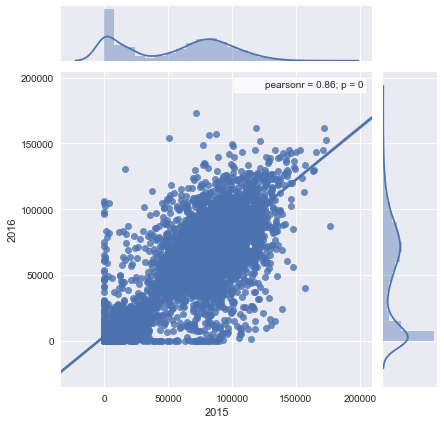

In [8]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    g = sns.jointplot("2015", "2016", data=df_two, kind="reg")

## Train Test Split

By performing the 0.2 size train test split, we replicated the distribution we observed in sections before.

In [9]:
X_train, X_test, y_train, y_test = bd.train_split(data, 'trip_total', seed=999, filename="Base")

Text(0.5,1,'Test Data')

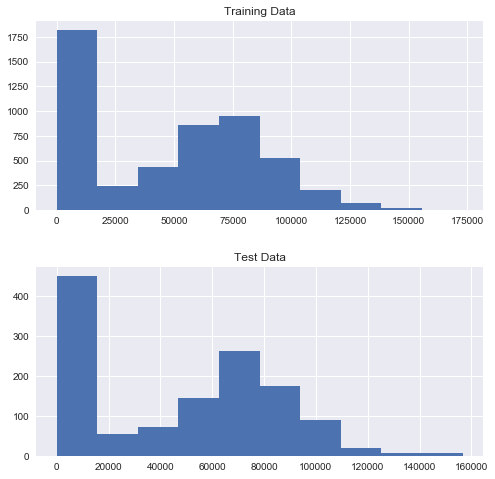

In [10]:
fig, ax = plt.subplots(2,1,figsize=(8,8))

y_train.hist(ax=ax[0])
ax[0].set_title("Training Data")
y_test.hist(ax=ax[1])
ax[1].set_title("Test Data")

## Baseline: Linear Regression

### Cross Validations

In the 3-fold cross validations on the training data, we plotted the RMSE as the main metric to evaluate if our model is working. The black bar indicates the lowest/highest volatile scores.

> Note: Test here means in-sample test data in each CV validate fold.

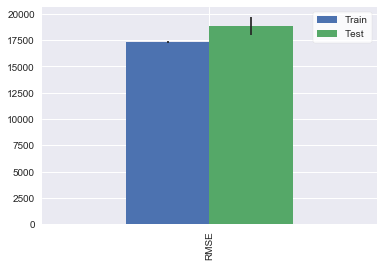

In [11]:
lin_reg = LinearRegression()
score_MSE = {'MSE':make_scorer(mean_squared_error)}
cv_results=cross_validate(lin_reg, X_train, y_train,scoring=score_MSE,return_train_score=True)

erros = {
    "Train": [[np.sqrt(cv_results['train_MSE'].mean())- np.sqrt(cv_results['train_MSE'].min()),
     np.sqrt(cv_results['train_MSE'].max())- np.sqrt(cv_results['train_MSE'].mean())]],
    "Test": [[np.sqrt(cv_results['test_MSE'].mean())- np.sqrt(cv_results['test_MSE'].min()),
     np.sqrt(cv_results['test_MSE'].max())- np.sqrt(cv_results['test_MSE'].mean())]]
}

df = pd.DataFrame({
    'Train': np.sqrt(cv_results['train_MSE'].mean()),
    'Test': np.sqrt(cv_results['test_MSE'].mean())
}, index=['RMSE']).plot(kind='bar', yerr=erros)

### Predictions

By sorting the predictions by the order of the size of actual 2016 revenues, we have plots as below:

* Linear Regression can even have negative predictions which won't make sense
* It failed the prediction harder when extreme values come in, for both low and high values.

In [12]:
lin_reg.fit(X_train, y_train)
y_train_predict = lin_reg.predict(X_train)
y_test_predict = lin_reg.predict(X_test)

In [13]:
y_train_sort = y_train.sort_values('trip_total')
y_train_predict_sort = lin_reg.predict(X_train.loc[y_train_sort.index])

y_test_sort =  y_test.sort_values('trip_total')
y_test_predict_sort = lin_reg.predict(X_test.loc[y_test_sort.index])

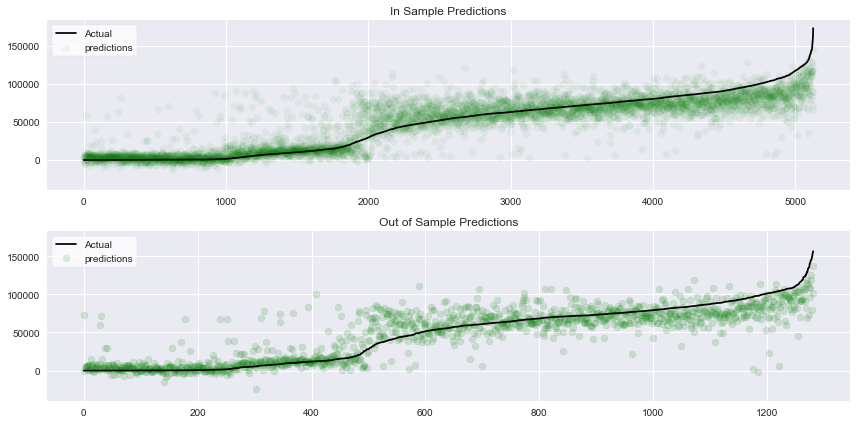

In [14]:
fig, ax = plt.subplots(2,1,figsize=(12,6), sharey=True)

ax[0].scatter(range(len(y_train_sort)), y_train_predict_sort,alpha=0.05, label='predictions', c='g')
ax[0].plot(range(len(y_train_sort)), y_train_sort.values, label='Actual',color='black')
ax[0].set_title("In Sample Predictions")
ax[0].legend()

ax[1].scatter(range(len(y_test_sort)), y_test_predict_sort,alpha=0.15, label='predictions', c='g')
ax[1].plot(range(len(y_test_sort)), y_test_sort.values, label='Actual',color='black')
ax[1].set_title("Out of Sample Predictions")
ax[1].legend()

fig.tight_layout()

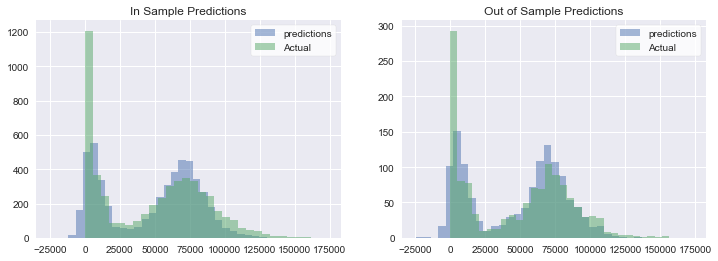

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12,4),sharex=True)

ax[0].hist(y_train_predict_sort,bins=30,alpha=0.5, label='predictions')
ax[0].hist(y_train_sort.values,bins=30,alpha=0.5, label='Actual')
ax[0].set_title("In Sample Predictions")
ax[0].legend()
ax[1].hist(y_test_predict_sort,bins=30,alpha=0.5, label='predictions')
ax[1].hist(y_test_sort.values,bins=30,alpha=0.5, label='Actual')
ax[1].set_title("Out of Sample Predictions")
ax[1].legend()


### Residuals

By looking at its errors, the conclusion aligns with the plots above. Linear regression model tends to overestimate low revenue taxi and underestimate high revenue taxi. 

We hope to improve this by applying another machine-learning based model.

In [16]:
e_in_sample = y_train_predict_sort - y_train_sort
e_oos = y_test_predict_sort -  y_test_sort

Text(0.5,0,'Actual Revenue')

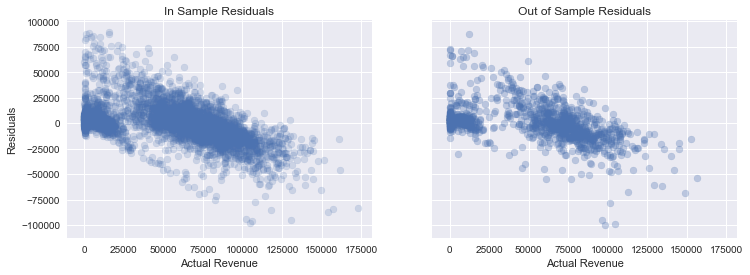

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12,4),sharex=True, sharey=True)


ax[0].scatter(y_train_sort.values, e_in_sample, alpha=0.2)
ax[0].set_title("In Sample Residuals")
ax[0].set_ylabel("Residuals")
ax[0].set_xlabel("Actual Revenue")
ax[1].scatter(y_test_sort.values,e_oos,alpha=0.3)
ax[1].set_title("Out of Sample Residuals")
ax[1].set_xlabel("Actual Revenue")

## AdaBoosting Regression

In [19]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.6f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [25]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import time

scoring = make_scorer(score_func=mean_squared_error, greater_is_better=False)
abr = AdaBoostRegressor(random_state=10)
param_grid = {'n_estimators': [20,25,30,35,40],
             'learning_rate': [0.001,0.004,0.007,0.01],
             'loss': ['linear','square','exponential']
             }
kf = KFold(n_splits=5)

grid_search_abr = GridSearchCV(estimator=abr, param_grid=param_grid, scoring=scoring, cv=kf, n_jobs=-1)
start = time.time()
grid_search_abr.fit(X_train,y_train)

print('GridSearchCV took {:.4f} seconds for {:d} candidate parameter settings.'.\
      format(time.time()-start,len(grid_search_abr.cv_results_['params'])))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV took 785.0957 seconds for 60 candidate parameter settings.


In [26]:
report(grid_search_abr.cv_results_,5)

Model with rank: 1
Mean validation score: -335910663.724404 (std: 20283254.326)
Parameters: {'learning_rate': 0.01, 'loss': 'square', 'n_estimators': 40}

Model with rank: 2
Mean validation score: -335916099.556945 (std: 19416118.193)
Parameters: {'learning_rate': 0.004, 'loss': 'square', 'n_estimators': 40}

Model with rank: 3
Mean validation score: -336146603.896887 (std: 20292981.253)
Parameters: {'learning_rate': 0.007, 'loss': 'linear', 'n_estimators': 40}

Model with rank: 4
Mean validation score: -336485114.220306 (std: 21089288.925)
Parameters: {'learning_rate': 0.007, 'loss': 'square', 'n_estimators': 40}

Model with rank: 5
Mean validation score: -336608041.892766 (std: 20933623.823)
Parameters: {'learning_rate': 0.01, 'loss': 'square', 'n_estimators': 35}



In [65]:
y_predict = grid_search_abr.best_estimator_.predict(X_test)
y_insample = grid_search_abr.best_estimator_.predict(X_train)
print('The mean squared error of AdaBoostRegressor with the best tuning is {:.6f}.'.\
      format(mean_squared_error(y_test,y_predict)))

The mean squared error of AdaBoostRegressor with the best tuning is 321494558.627266.


In [90]:
y_train_sort = y_train.sort_values('trip_total')
y_train_predict_sort = grid_search_abr.best_estimator_.predict(X_train.loc[y_train_sort.index])

y_test_sort =  y_test.sort_values('trip_total')
y_test_predict_sort = grid_search_abr.best_estimator_.predict(X_test.loc[y_test_sort.index])

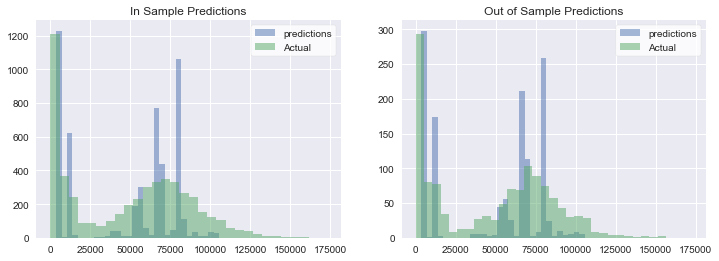

In [91]:
fig, ax = plt.subplots(1, 2, figsize=(12,4),sharex=True)

ax[0].hist(y_train_predict_sort,bins=30,alpha=0.5, label='predictions')
ax[0].hist(y_train_sort.values,bins=30,alpha=0.5, label='Actual')
ax[0].set_title("In Sample Predictions")
ax[0].legend()
ax[1].hist(y_test_predict_sort,bins=30,alpha=0.5, label='predictions')
ax[1].hist(y_test_sort.values,bins=30,alpha=0.5, label='Actual')
ax[1].set_title("Out of Sample Predictions")
ax[1].legend()

In [92]:
fig.savefig('AdaBoost_Pic1.png',dpi=100)

Text(0.5,0,'Actual Revenue')

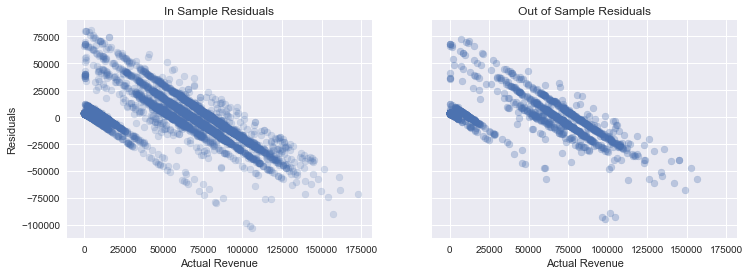

In [93]:
e_in_sample = y_train_predict_sort - y_train_sort.values.flatten()
e_oos = y_test_predict_sort -  y_test_sort.values.flatten()

fig, ax = plt.subplots(1, 2, figsize=(12,4),sharex=True, sharey=True)
ax[0].scatter(y_train_sort.values, e_in_sample, alpha=0.2)
ax[0].set_title("In Sample Residuals")
ax[0].set_ylabel("Residuals")
ax[0].set_xlabel("Actual Revenue")
ax[1].scatter(y_test_sort.values,e_oos,alpha=0.3)
ax[1].set_title("Out of Sample Residuals")
ax[1].set_xlabel("Actual Revenue")

In [94]:
fig.savefig('AdaBoost_Pic2.png',dpi=100)

In [33]:
from sklearn.externals import joblib

filename = 'AdaBoost_modelBest.sav'
joblib.dump(grid_search_abr.best_estimator_,filename)

['AdaBoost_modelBest.sav']

## Decision Tree Regression

In [28]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import time

scoring = make_scorer(score_func=mean_squared_error, greater_is_better=False)
dtr = DecisionTreeRegressor(random_state=10)
param_grid = {'max_depth': list(range(5,14)),
             'min_samples_leaf': list(range(1,6))
             }
kf = KFold(n_splits=5)

grid_search_dtr = GridSearchCV(estimator=dtr, param_grid=param_grid, scoring=scoring, cv=kf, n_jobs=-1)
start = time.time()
grid_search_dtr.fit(X_train,y_train)

print('GridSearchCV took {:.4f} seconds for {:d} candidate parameter settings.'.\
      format(time.time()-start,len(grid_search_dtr.cv_results_['params'])))

GridSearchCV took 58.6370 seconds for 45 candidate parameter settings.


In [29]:
report(grid_search_dtr.cv_results_,5)

Model with rank: 1
Mean validation score: -357902189.277483 (std: 21965079.325)
Parameters: {'max_depth': 5, 'min_samples_leaf': 5}

Model with rank: 2
Mean validation score: -360075560.968979 (std: 22548046.998)
Parameters: {'max_depth': 5, 'min_samples_leaf': 4}

Model with rank: 3
Mean validation score: -363227890.062003 (std: 21668957.439)
Parameters: {'max_depth': 5, 'min_samples_leaf': 3}

Model with rank: 4
Mean validation score: -363889497.648061 (std: 21289103.625)
Parameters: {'max_depth': 5, 'min_samples_leaf': 2}

Model with rank: 5
Mean validation score: -364694086.698397 (std: 24691346.859)
Parameters: {'max_depth': 6, 'min_samples_leaf': 5}



In [70]:
y_predict = grid_search_dtr.best_estimator_.predict(X_test)
y_insample = grid_search_dtr.best_estimator_.predict(X_train)
print('The mean squared error of AdaBoostRegressor with the best tuning is {:.6f}.'.\
      format(mean_squared_error(y_test,y_predict)))

The mean squared error of AdaBoostRegressor with the best tuning is 325230117.980908.


In [95]:
y_train_sort = y_train.sort_values('trip_total')
y_train_predict_sort = grid_search_dtr.best_estimator_.predict(X_train.loc[y_train_sort.index])

y_test_sort =  y_test.sort_values('trip_total')
y_test_predict_sort = grid_search_dtr.best_estimator_.predict(X_test.loc[y_test_sort.index])

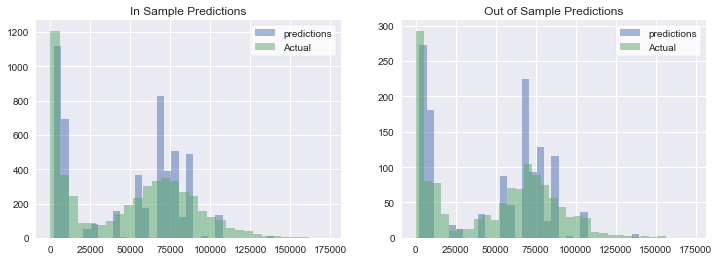

In [96]:
fig, ax = plt.subplots(1, 2, figsize=(12,4),sharex=True)

ax[0].hist(y_train_predict_sort,bins=30,alpha=0.5, label='predictions')
ax[0].hist(y_train_sort.values,bins=30,alpha=0.5, label='Actual')
ax[0].set_title("In Sample Predictions")
ax[0].legend()
ax[1].hist(y_test_predict_sort,bins=30,alpha=0.5, label='predictions')
ax[1].hist(y_test_sort.values,bins=30,alpha=0.5, label='Actual')
ax[1].set_title("Out of Sample Predictions")
ax[1].legend()

In [97]:
fig.savefig('DecisionTreeRegression_Pic1.png',dpi=100)

Text(0.5,0,'Actual Revenue')

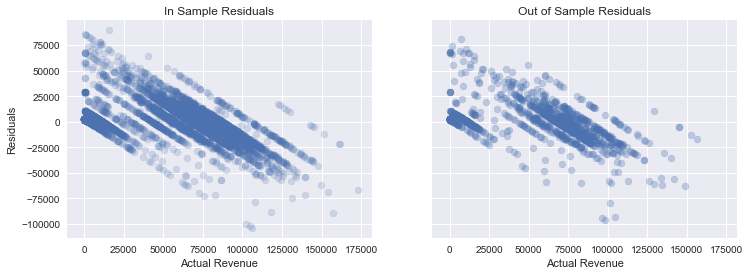

In [98]:
e_in_sample = y_train_predict_sort - y_train_sort.values.flatten()
e_oos = y_test_predict_sort -  y_test_sort.values.flatten()

fig, ax = plt.subplots(1, 2, figsize=(12,4),sharex=True, sharey=True)
ax[0].scatter(y_train_sort.values, e_in_sample, alpha=0.2)
ax[0].set_title("In Sample Residuals")
ax[0].set_ylabel("Residuals")
ax[0].set_xlabel("Actual Revenue")
ax[1].scatter(y_test_sort.values,e_oos,alpha=0.3)
ax[1].set_title("Out of Sample Residuals")
ax[1].set_xlabel("Actual Revenue")

In [99]:
fig.savefig('DecisionTreeRegression_Pic2.png',dpi=100)

In [34]:
from sklearn.externals import joblib

filename = 'DecisionTree_modelBest.sav'
joblib.dump(grid_search_dtr.best_estimator_,filename)

['DecisionTree_modelBest.sav']